In [1]:
import pandas as pd
import anndata
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from ALLCools.plot import *
from annoy import AnnoyIndex
import scanpy as sc

In [19]:
def co_clustering(adata, resolution):
    sc.tl.leiden(adata, resolution=resolution)
    record = {}
    for cluster, sub_group in adata.obs.groupby('leiden'):
        cell_dup = sub_group.index.str[:-4].value_counts()
        accuracy = (cell_dup == 2).sum() / cell_dup.size
        record[cluster] = {
            'acc': accuracy,
            'n_acc': (cell_dup == 2).sum(),
            'n_split': (cell_dup == 1).sum(),
            'n_mch': sub_group.index.str.endswith('mch').sum(),
            'n_rna': sub_group.index.str.endswith('rna').sum(),
            'n_unique': cell_dup.size,
            'size': sub_group.shape[0]
        }
    return pd.DataFrame(record).T


def plot_summary(table, name):
    table = table.sort_values('size', ascending=False)
    total_acc = table['n_acc'].sum() / table['n_unique'].sum()

    fig = plt.figure(figsize=(4, 3), dpi=300)
    n_cluster = table.shape[0]
    gs = fig.add_gridspec(nrows=2, ncols=n_cluster + 2)
    ax = fig.add_subplot(gs[0, :-2])
    sns.barplot(ax=ax, x=table.index, y=table['size'], color='orange')
    sns.barplot(ax=ax, x=table.index, y=table['n_mch'], color='steelblue')
    ax.set(xticks=[], ylabel='Number of\ncells', title=name)
    sns.despine(ax=ax)

    ax = fig.add_subplot(gs[1, :-2])
    sns.barplot(ax=ax, x=table.index, y=table['acc'], color='gray')
    ax.set(xticks=[],
           ylim=(0, 1),
           yticks=(0, 1),
           yticklabels=('0%', '100%'),
           xlabel=f'{n_cluster} co-clusters',
           ylabel='Fraction of\nconsistent cells')
    sns.despine(ax=ax)

    ax = fig.add_subplot(gs[1, -1:])
    sns.barplot(ax=ax, x=[''], y=[total_acc], color='gray')
    ax.text(0, total_acc, f'{total_acc*100:.1f}%', ha='center', va='bottom')
    ax.text(0, -0.18, 'Overall', ha='center', va='bottom')
    ax.set(xticks=[], ylim=(0, 1), yticks=[], xlabel='')
    sns.despine(ax=ax, left=True)
    fig.savefig(f'Coclustering.{name}.pdf')

## Harmony

In [3]:
harmony_adata = anndata.read_h5ad('harmony.Seurat_HVGs.2000hvg.h5ad')
harmony_major = co_clustering(harmony_adata, resolution=1)
harmony_major_acc = harmony_major['n_acc'].sum(
) / harmony_major['n_unique'].sum()
print(harmony_major.shape[0], f'{harmony_major_acc:.3f}')

17 0.480


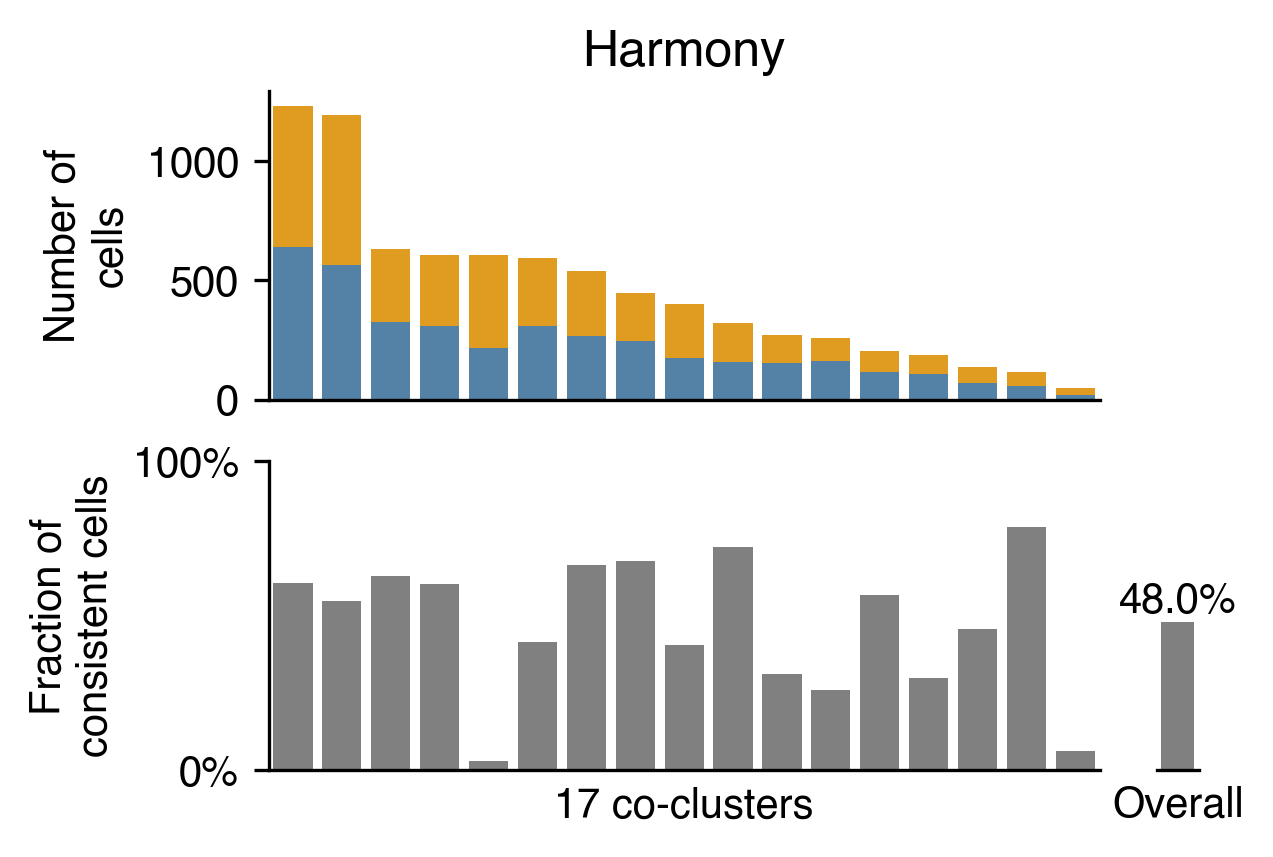

In [20]:
plot_summary(harmony_major, 'Harmony')

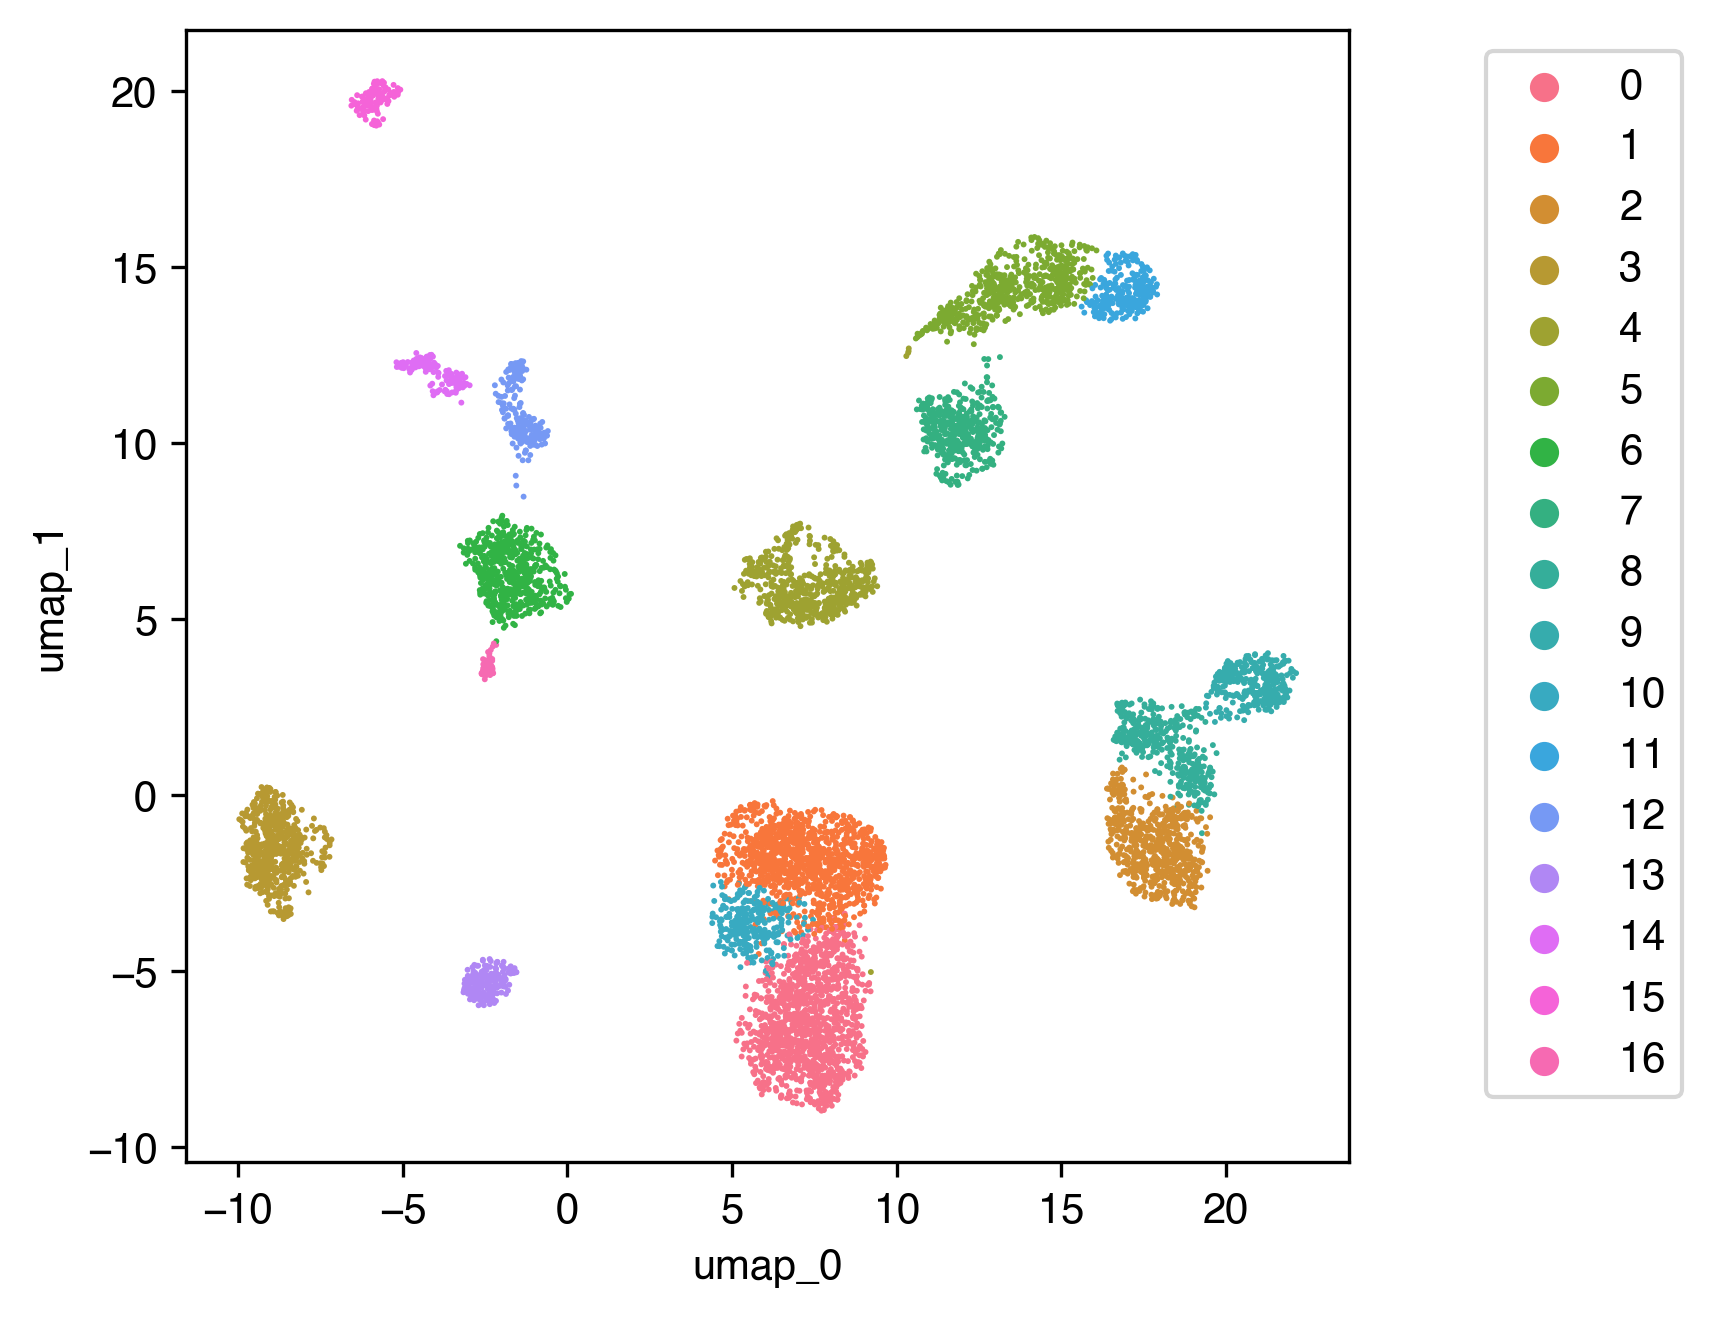

In [5]:
fig, ax = plt.subplots(figsize=(5, 5), dpi=300)

sns.scatterplot(ax=ax,
                data=harmony_adata.obs,
                x='umap_0',
                y='umap_1',
                hue='leiden',
                s=2,
                linewidth=0)
ax.legend(bbox_to_anchor=[1.1, 1])

## Seurat

In [6]:
seurat_adata = harmony_adata.copy()

seurat_meta = pd.read_csv('../mCTN/dataset/ForSeurat/Metadata.csv.gz', index_col=0)
seurat_order = seurat_meta[seurat_meta['ClusterAnno'] != ''].index
seurat_index = pd.Index((seurat_order+'_mch').tolist() + (seurat_order+'_rna').tolist())
seurat_index = seurat_index[seurat_index.isin(seurat_adata.obs_names)]

pc = pd.read_hdf('Seurat.integrated.PCs.hdf')
pc.index = seurat_index
seurat_adata.obsm['X_pca'] = pc.reindex(seurat_adata.obs_names).values

umap = pd.read_hdf('Seurat.integrated.UMAP.hdf')
umap.index = seurat_index
seurat_adata.obsm['X_umap'] = umap.reindex(seurat_adata.obs_names).values
seurat_adata.obs['umap_0'] = seurat_adata.obsm['X_umap'][:, 0]
seurat_adata.obs['umap_1'] = seurat_adata.obsm['X_umap'][:, 1]

In [7]:
sc.pp.neighbors(seurat_adata)

In [8]:
seurat_major = co_clustering(seurat_adata, resolution=0.48)
seurat_major_acc = seurat_major['n_acc'].sum(
) / seurat_major['n_unique'].sum()
print(seurat_major.shape[0], f'{seurat_major_acc:.3f}')

17 0.693


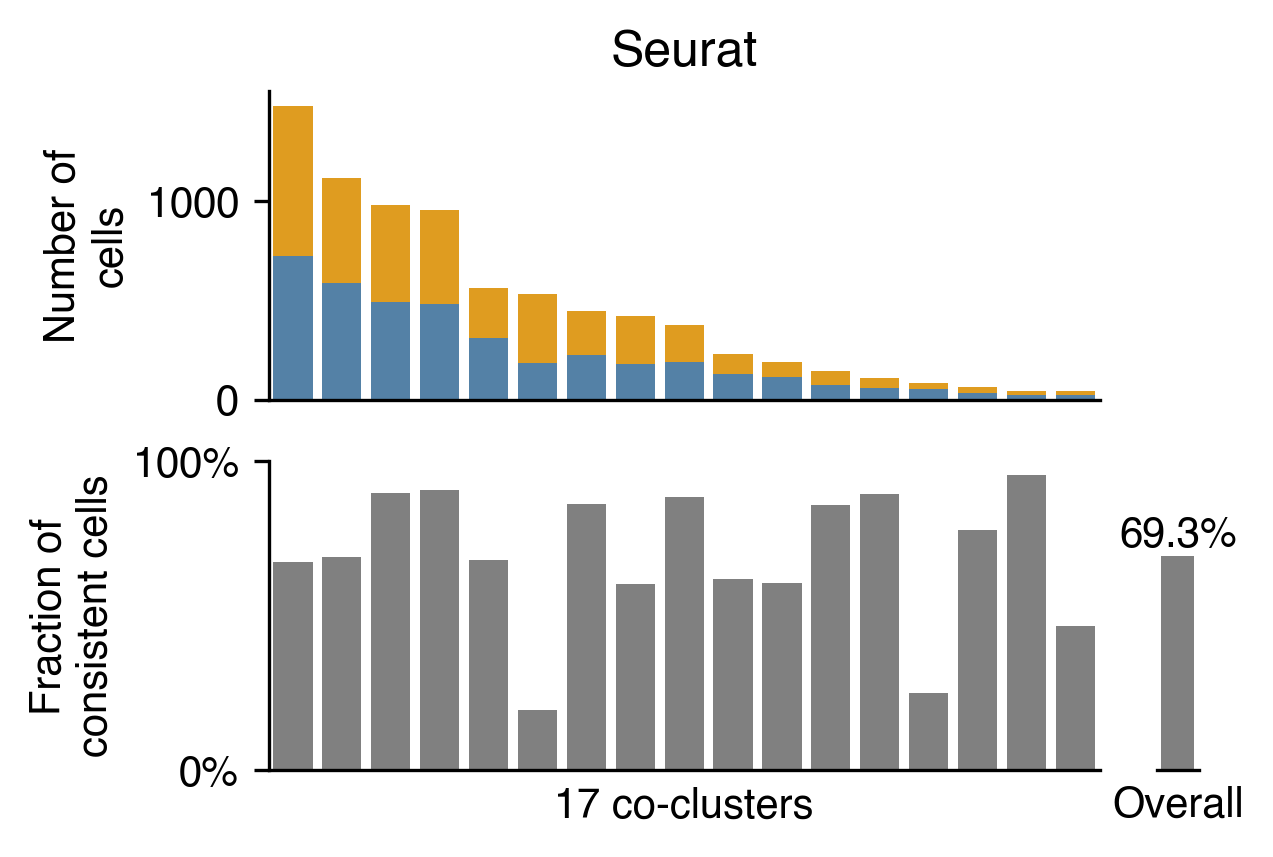

In [21]:
plot_summary(seurat_major, 'Seurat')

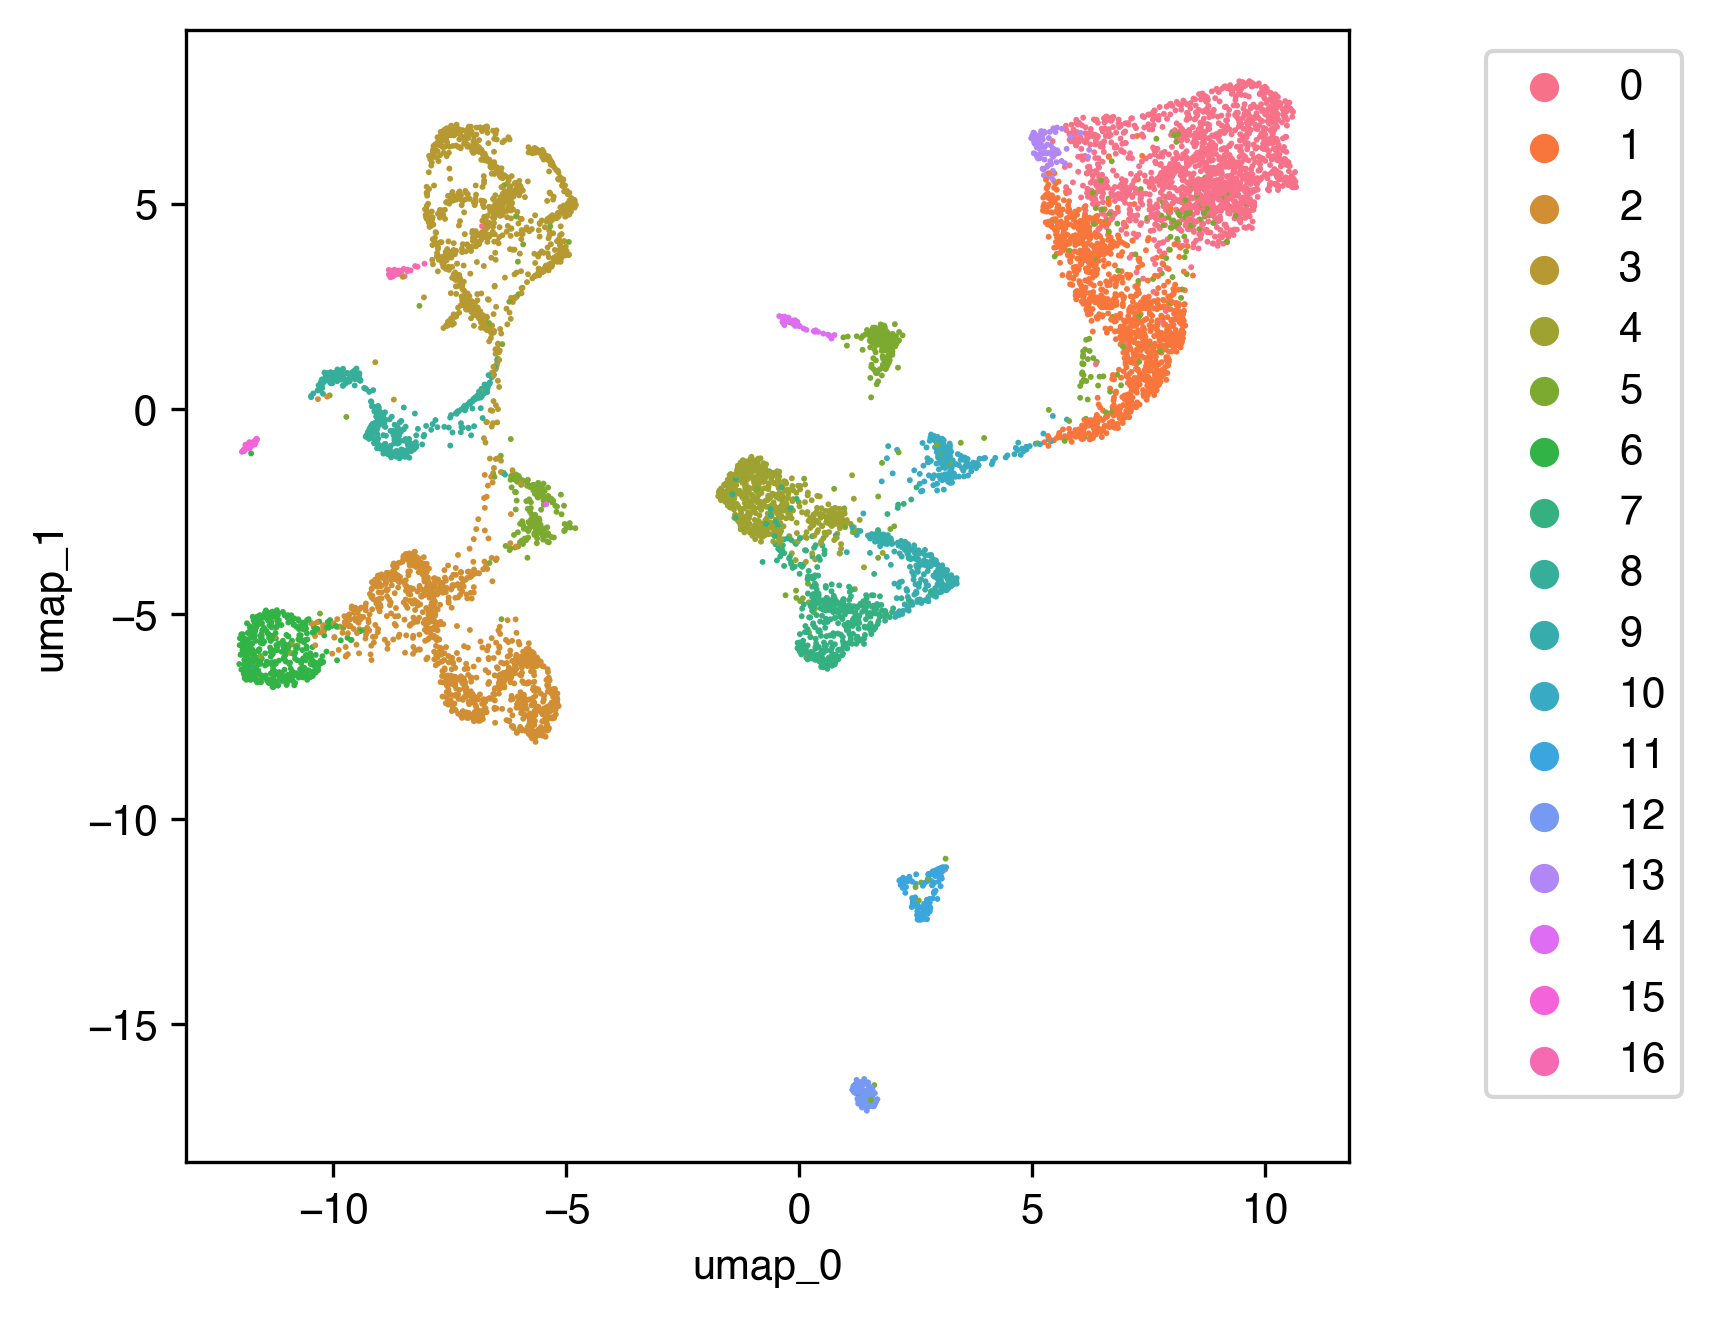

In [10]:
fig, ax = plt.subplots(figsize=(5, 5), dpi=300)

sns.scatterplot(ax=ax,
                data=seurat_adata.obs,
                x='umap_0',
                y='umap_1',
                hue='leiden',
                s=2,
                linewidth=0)
ax.legend(bbox_to_anchor=[1.1, 1])

## Scanorama

In [11]:
scanorama_adata = anndata.read_h5ad('scanorama.Seurat_HVGs.2000hvg.h5ad')
scanorama_major = co_clustering(scanorama_adata, resolution=0.6)
scanorama_major_acc = scanorama_major['n_acc'].sum(
) / scanorama_major['n_unique'].sum()
print(scanorama_major.shape[0], f'{harmony_major_acc:.3f}')

17 0.480


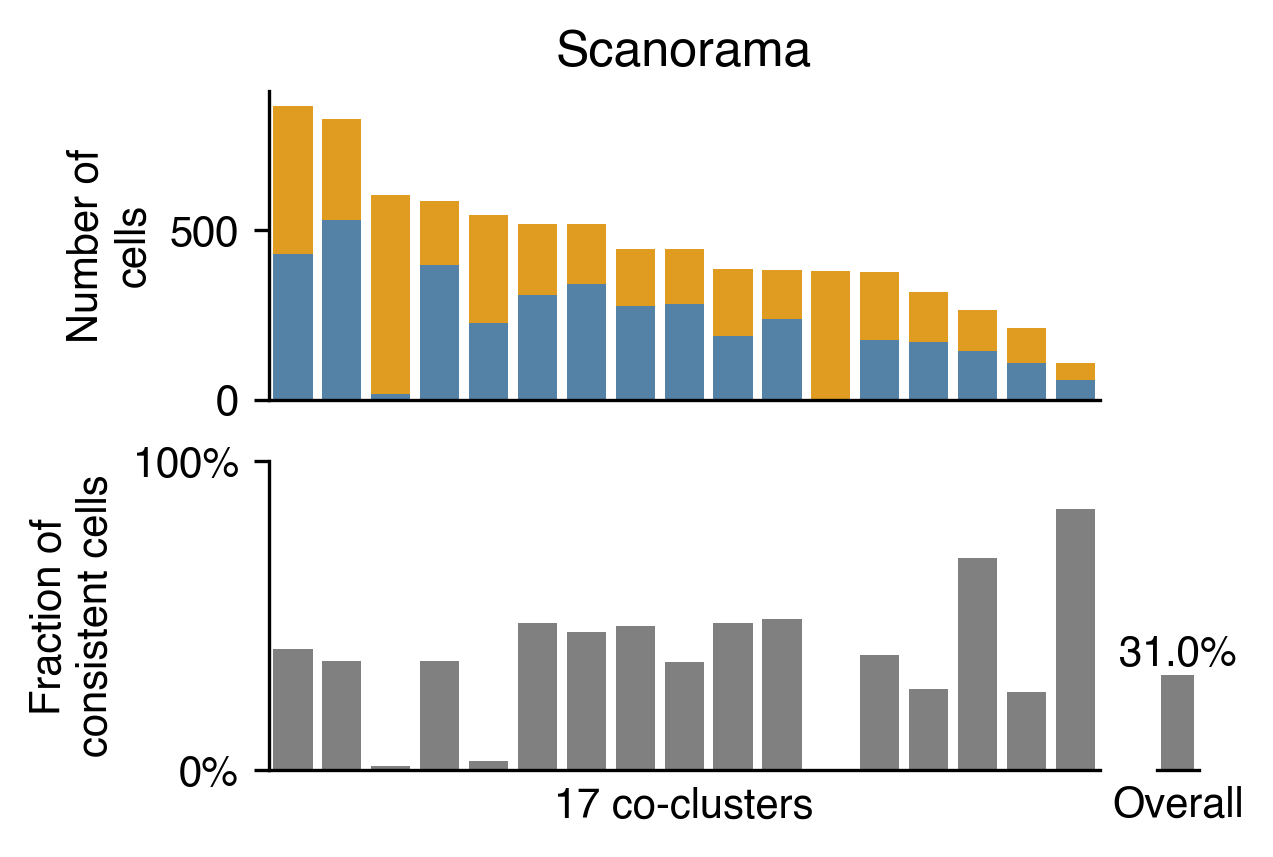

In [22]:
plot_summary(scanorama_major, 'Scanorama')

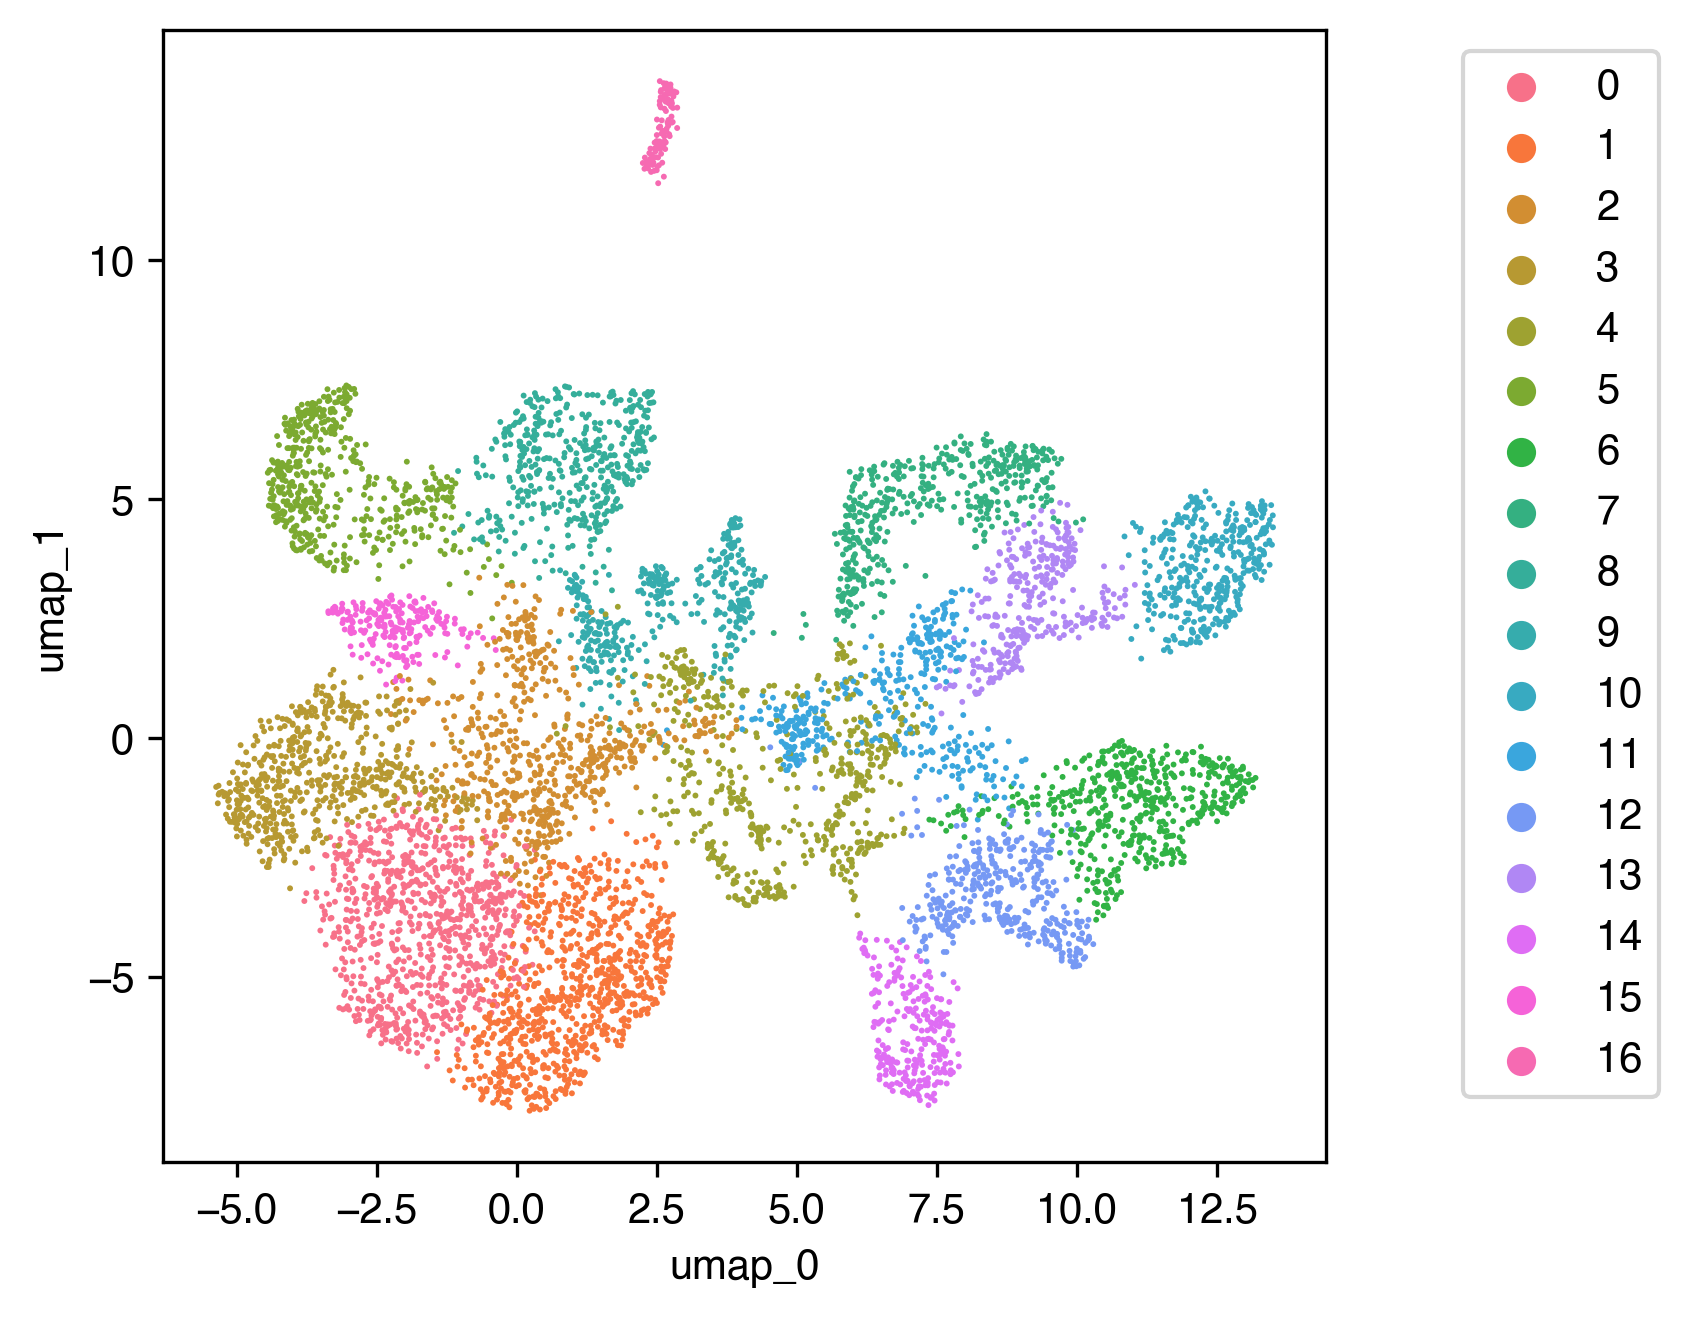

In [13]:
fig, ax = plt.subplots(figsize=(5, 5), dpi=300)

sns.scatterplot(ax=ax,
                data=scanorama_adata.obs,
                x='umap_0',
                y='umap_1',
                hue='leiden',
                s=2,
                linewidth=0)
ax.legend(bbox_to_anchor=[1.1, 1])

## LIGER

In [14]:
liger_adata = harmony_adata.copy()

pc = pd.read_csv('LIGER.H.norm.txt')
liger_adata.obsm['X_pca'] = pc.reindex(liger_adata.obs_names).values

sc.pp.neighbors(liger_adata)
sc.tl.umap(liger_adata)

liger_adata.obs['umap_0'] = liger_adata.obsm['X_umap'][:, 0]
liger_adata.obs['umap_1'] = liger_adata.obsm['X_umap'][:, 1]

In [15]:
liger_major = co_clustering(liger_adata, resolution=0.46)
liger_major_acc = liger_major['n_acc'].sum(
) / liger_major['n_unique'].sum()
print(liger_major.shape[0], f'{liger_major_acc:.3f}')

17 0.336


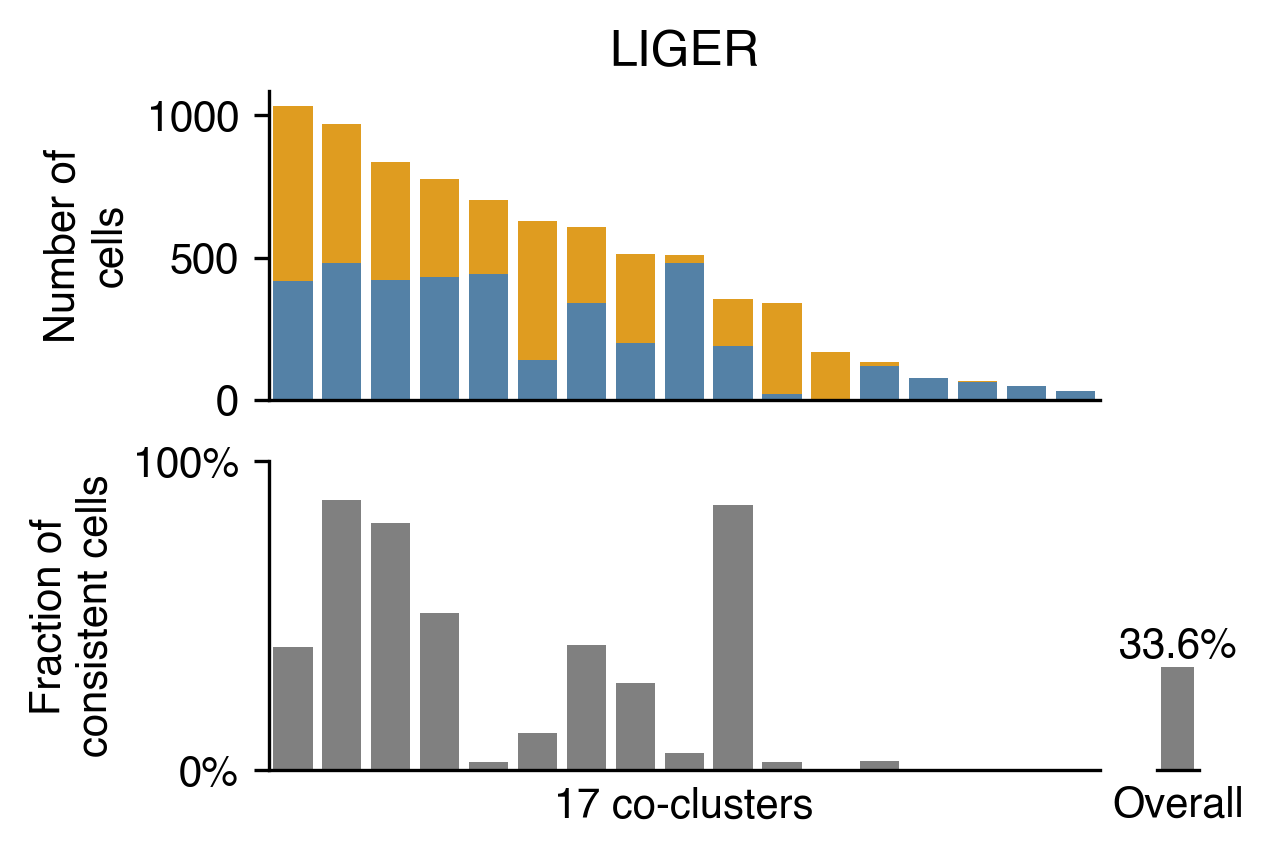

In [23]:
plot_summary(liger_major, 'LIGER')

AttributeError: 'DataFrame' object has no attribute 'obs'

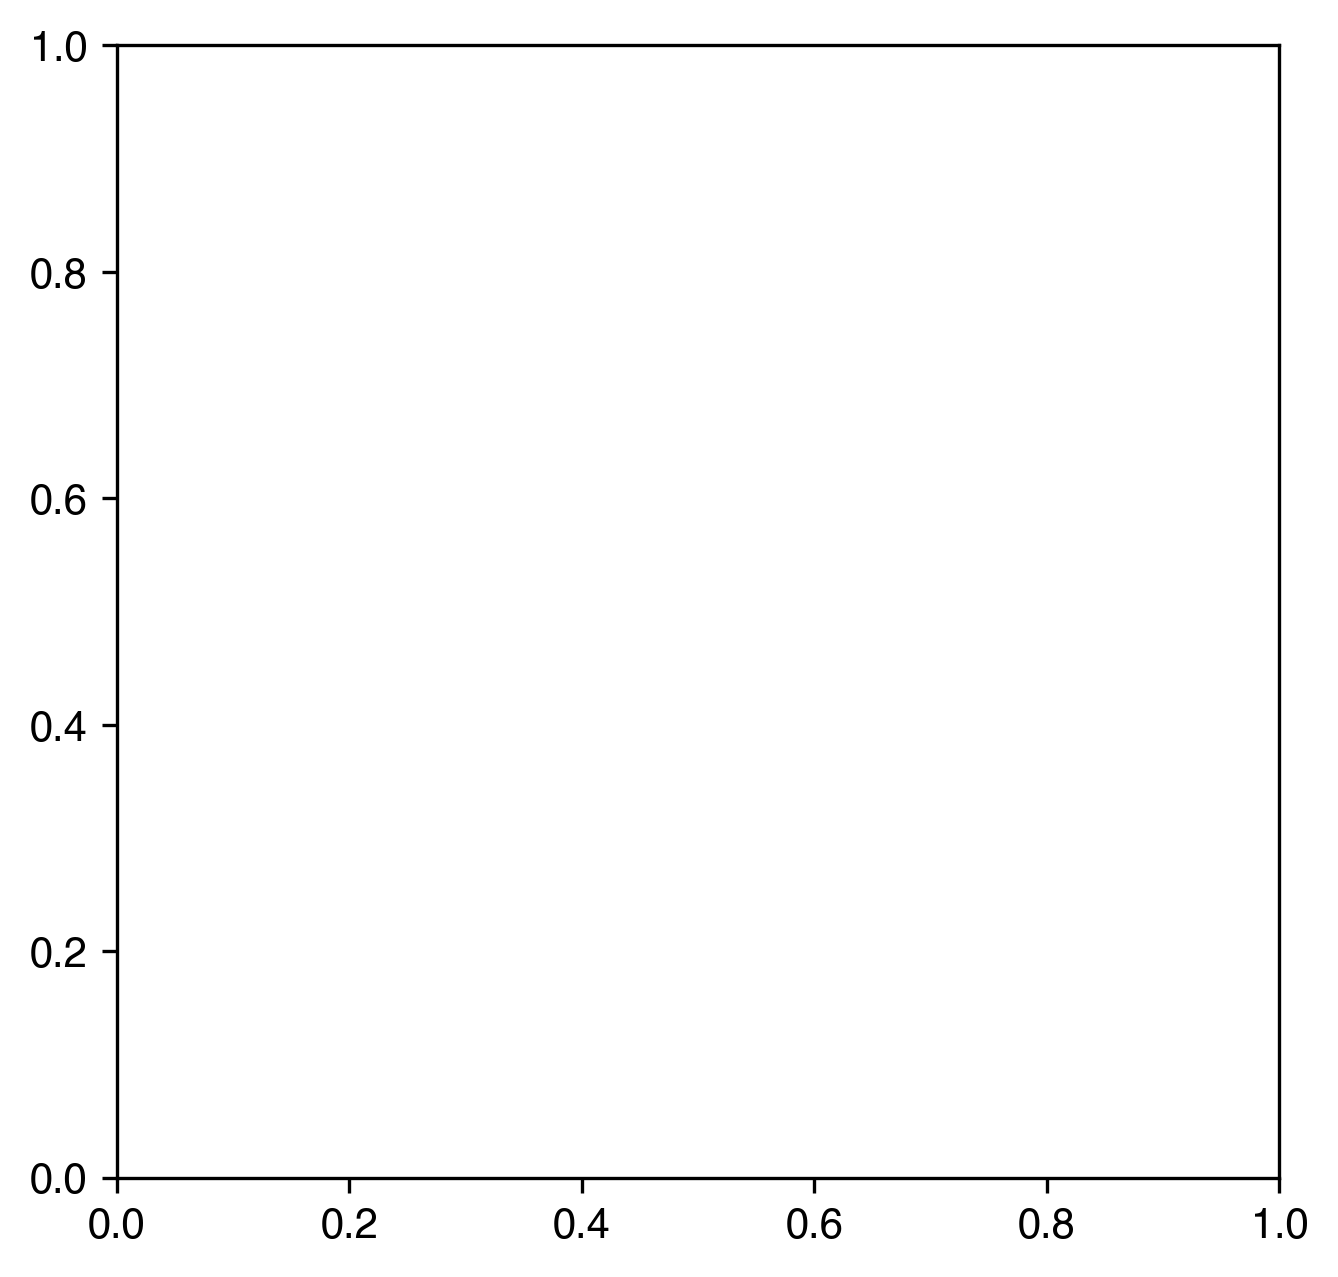

In [17]:
fig, ax = plt.subplots(figsize=(5, 5), dpi=300)

sns.scatterplot(ax=ax,
                data=liger_major.obs,
                x='umap_0',
                y='umap_1',
                hue='leiden',
                s=2,
                linewidth=0)
ax.legend(bbox_to_anchor=[1.1, 1])